## MG1 experiments

In [1]:
# Importing all packages
# normalizing flows packages
import torch
from torch.distributions.beta import Beta

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores, LambdaScore, WaldoScore, BFFScore, E_valueScore
from CP2LFI.posterior_models import normflow_posterior
from clover import LocartSplit

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import itertools
import pandas as pd

# utils functions
from CP2LFI.utils import obtain_quantiles, fit_post_model

# package to simulate from tractable
from hypothesis.benchmark import mg1

Function to compute MAE for fixed $n$ and $B$:

In [2]:
# function to compute MAE for a single N and B
def compute_MAE_N_B(
    kind,
    score,
    theta_grid_eval,
    simulator,
    prior,
    N = 5,
    B = 10000,
    alpha=0.05,
    min_samples_leaf = 300,
    n_estimators = 200,
    K = 50,
    B_valid= 500,
    N_lambda = 250,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 95, 5))),
    naive_n=500,
    disable_tqdm = True,
    seed = 45,
    n_lambda = 300,
    log_transf = False,
    split_calib = False,
    using_beta = False,
):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    quantiles_dict = obtain_quantiles(
    kind = kind, 
    score = score, 
    theta_grid_eval = theta_grid_eval, 
    simulator = simulator,
    prior = prior, 
    N = N, 
    B = B, 
    alpha = alpha, 
    min_samples_leaf = min_samples_leaf, 
    n_estimators = n_estimators, 
    K = K,
    disable_tqdm = disable_tqdm,
    B_valid = B_valid,
    N_lambda= N_lambda,
    K_grid = K_grid,
    naive_n = naive_n,
    log_transf = log_transf,
    split_calib = split_calib,
    using_beta = using_beta,
)
    mae_list, se_list, methods_list, N_list, B_list = [], [], [], [], []
    err_data = np.zeros((theta_grid_eval.shape[0], 5))
    l = 0
    for theta in tqdm(theta_grid_eval, desc = "Evaluating coverage in this setting"):
        if theta_grid_eval.ndim == 1:
            theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*N, dim = 0)
        else:
            theta_repeated = torch.tensor([theta]).repeat_interleave(repeats = n_lambda*N, dim = 0)
            
        # simulating lambdas for testing
        X_net = simulator(theta_repeated)
        if log_transf:
            X_net = torch.log(X_net)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, N * X_dim)

        stat = score.compute(theta_repeated.numpy()[0:n_lambda, :], X_net.numpy(), disable_tqdm = True)
                
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest_fixed"][l])
        loforest_tuned_cover = np.mean(stat <= quantiles_dict["loforest_tuned"][l])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][l])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_loforest_tuned = np.abs(loforest_tuned_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))
        
            # saving in numpy array
        err_data[l, :] = np.array([err_locart, err_loforest, err_loforest_tuned, err_boosting, err_naive])
        l += 1

    mae_list.extend(np.mean(err_data, axis=0).tolist())
    se_list.extend((np.std(err_data, axis=0) / np.sqrt(theta_grid_eval.shape[0])).tolist())
    methods_list.extend(["LOCART", "LOFOREST", "tuned LOFOREST", "boosting", "monte-carlo"])
    N_list.extend([N] * 5)
    B_list.extend([B] * 5)

    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

Fixing simulator and grid of evaluation:

In [3]:
simulator = mg1.MG1Simulator()
prior = mg1.Prior()

# mg1 grid
n_par = 8
pars_1 = np.linspace(0.1, 9.9, n_par)
pars_2 = np.linspace(0.01, 1/3 - 0.01, n_par)
thetas_valid = np.c_[list(itertools.product(pars_1, pars_1, pars_2))]

Fitting posterior model for $n = 5$:

Fitting normalizing flows posterior estimator:  80%|████████  | 1602/2000 [15:52<03:56,  1.68it/s]

Early stopping at epoch 1602
a


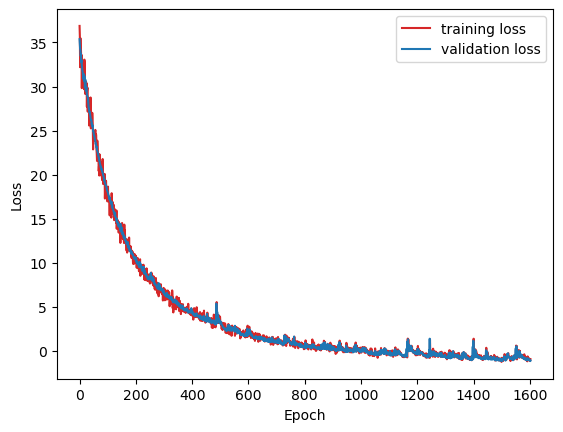

In [4]:
nflow_post_mg1 = fit_post_model(
    simulator = simulator, 
    prior = prior, 
    B_model = 20000, 
    n = 5, 
    seed = 0, 
    split_seed = 125, 
    patience = 100,
    n_flows = 6,
    log_transf = True
    )

Defining scores:

In [5]:
# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post_mg1, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post_mg1, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post_mg1, is_fitted = True)
e_value_score.fit()

Comparing all models for $n = 5$:

In [6]:
bff_stats_mg1_beta = compute_MAE_N_B(
    kind = "mg1", 
    score = bff_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    seed = 125,
    K = 70,
    n_estimators = 250,
    min_samples_leaf = 300,
    log_transf = True,
    split_calib = False,
    using_beta = True,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 130, 5))),
    )

Running naive method


fitting monte carlo cutoffs: 27it [00:15,  1.80it/s]


[-1.7004912  -2.7622876  -8.36297    ... -0.07482554 -9.775992
 -1.9073789 ]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [10:06<00:00,  1.65it/s]


Fitting tuned loforest


Evaluating coverage in this setting:   0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_73836/2174111211.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/utils/tensor_new.cpp:275.)
  theta_repeated = torch.tensor([theta]).repeat_interleave(repeats = n_lambda*N, dim = 0)
Evaluating coverage in this setting: 100%|██████████| 512/512 [03:45<00:00,  2.27it/s]


In [7]:
bff_stats_mg1_beta

,methods,N,B,MAE,se
0,LOCART,5,10000,0.065638,0.004361
1,LOFOREST,5,10000,0.060970,0.003458
2,tuned LOFOREST,5,10000,0.061745,0.003516
3,boosting,5,10000,0.072090,0.004046
4,monte-carlo,5,10000,0.156836,0.011537


In [8]:
waldo_stats_mg1_beta = compute_MAE_N_B(
    kind = "mg1", 
    score = waldo_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 300, 
    N_lambda = 150,
    seed = 125,
    K = 70,
    n_estimators = 250,
    min_samples_leaf = 300,
    log_transf = True,
    split_calib = False,
    using_beta = True,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 130, 5))),
    )

Running naive method


fitting monte carlo cutoffs: 27it [20:09, 44.81s/it]


[0.47288987 0.91130206 1.61196117 ... 1.65316354 0.62361965 0.43221861]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 300/300 [1:30:00<00:00, 18.00s/it]


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 512/512 [5:37:24<00:00, 39.54s/it]  


In [9]:
waldo_stats_mg1_beta

,methods,N,B,MAE,se
0,LOCART,5,10000,0.052135,0.003145
1,LOFOREST,5,10000,0.041230,0.002092
2,tuned LOFOREST,5,10000,0.041380,0.001706
3,boosting,5,10000,0.043444,0.002775
4,monte-carlo,5,10000,0.084362,0.007665


In [10]:
e_value_stats_mg1_beta = compute_MAE_N_B(
    kind = "mg1", 
    score = e_value_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 300, 
    N_lambda = 150,
    seed = 125,
    K = 70,
    n_estimators = 250,
    min_samples_leaf = 300,
    log_transf = True,
    split_calib = False,
    using_beta = True,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 130, 5))),
    )

Running naive method


fitting monte carlo cutoffs: 27it [1:08:10, 151.50s/it]


[0.473 0.456 0.028 ... 0.662 0.579 0.676]
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 300/300 [3:08:18<00:00, 37.66s/it]  


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 512/512 [6:43:23<00:00, 47.27s/it]  


In [11]:
e_value_stats_mg1_beta

,methods,N,B,MAE,se
0,LOCART,5,10000,0.053418,0.003532
1,LOFOREST,5,10000,0.047982,0.002840
2,tuned LOFOREST,5,10000,0.043841,0.001885
3,boosting,5,10000,0.059368,0.003344
4,monte-carlo,5,10000,0.101602,0.006588
